## Word Emeddings for Document Similarity

This notebook will introduce some code for training a Word2Vec model on the DBPedia corpus.

* Train a Word2Vec model with gensim
* Extract the embeddings
* Create a t-SNE plot of the embeddings
* Use the embeddings for document similarity.

#### Load the necessary libraries

In [37]:
%matplotlib inline
from sklearn.feature_extraction import stop_words
from sklearn.utils import shuffle
from wmd import get_wmd_distance
import matplotlib.pyplot as plt
from scipy import spatial
from gensim import utils
import numpy as np
import gensim
import random
import time
import nltk

#### Load the text file containing the wikipedia abstracts and set up functions to clean the text

In [38]:
with open('data/dbpedia.txt', 'r') as f:
    sentences = f.readlines()

def strip_non_ascii(string):
    # returns the string without non ASCII characters
    stripped = ([c if 0 < ord(c) < 128 else ' ' for c in string])
    return ''.join(stripped).split()

clean_text = []
for  text in sentences:
    # remove non ascii characters
    all_ascii = strip_non_ascii(text.lower())
    # remove stop words
    no_stops = [w for w in all_ascii if w not in stop_words.ENGLISH_STOP_WORDS]
    # remove all punctuation and numbers that are left
    cleaned = [w for w in no_stops if w.isalpha()]
    # append clean text to list
    clean_text.append(nltk.word_tokenize(' '.join(cleaned)))

print clean_text[0]

['abbott', 'abbott', 'farnham', 'e', 'd', 'abbott', 'limited', 'british', 'coachbuilding', 'business', 'based', 'farnham', 'surrey', 'trading', 'major', 'output', 'motor', 'vehicle', 'business', 'closed']


### Do the training and save the model for later

With word2vec it is possible to use a pretrained model and simply extract the embeddings for each word in your corpus. However, the downside here is that words have different meanings in different contexts. For example if we were trying to come up with some emebeddings for machine learning a pretrained model will get python wrong. It will give python a vector that is closest to snake and reptile vectors and not one that is like a programming language. 

For this specific example we are using wikipedia abstracts and the word2vec model was pretrained on millions of news articles so it may be a good match. But, we've got enough data to retrain and this is a tutorial. 

In [39]:
# model params
ITERS = 80
num_features = 64
min_word_count = 20
num_workers = 4

print 'Creating Word2Vec ... '
model = gensim.models.Word2Vec(size=num_features, workers=num_workers, iter=1, window=10,
                               min_count=min_word_count, sg=1)
print 'Building vocab ...'
model.build_vocab(clean_text)

# initialize the word2vec model
#model = gensim.models.Word2Vec(size=num_features, workers=num_workers, iter=80
#                               min_count=min_word_count, sg=1, min_alpha=0.00001)
print 'Training word2vec ... '
for epoch in range(ITERS):
    start = time.time()
    # shuffle text on each iteration
    text = shuffle(clean_text)
    model.train(clean_text)
    if model.alpha > 0.0001:
        model.alpha -= 0.0002
    end = time.time()
    print 'Iter:', epoch, 'Time:', end-start, 'Model LR:', model.alpha

#print 'Saving model ... '
model.save('dbpedia_w2v_model')

Creating Word2Vec ... 
Building vocab ...
Training word2vec ... 
Iter: 0 Time: 33.193114996 Model LR: 0.0248
Iter: 1 Time: 33.1403779984 Model LR: 0.0246
Iter: 2 Time: 32.3378310204 Model LR: 0.0244
Iter: 3 Time: 32.3938639164 Model LR: 0.0242
Iter: 4 Time: 31.9981470108 Model LR: 0.024
Iter: 5 Time: 31.911386013 Model LR: 0.0238
Iter: 6 Time: 31.8003339767 Model LR: 0.0236
Iter: 7 Time: 31.9423470497 Model LR: 0.0234
Iter: 8 Time: 31.7480521202 Model LR: 0.0232
Iter: 9 Time: 31.7692890167 Model LR: 0.023
Iter: 10 Time: 31.7623679638 Model LR: 0.0228
Iter: 11 Time: 31.7064619064 Model LR: 0.0226
Iter: 12 Time: 31.7736620903 Model LR: 0.0224
Iter: 13 Time: 31.6490478516 Model LR: 0.0222
Iter: 14 Time: 31.7444171906 Model LR: 0.022
Iter: 15 Time: 31.8027479649 Model LR: 0.0218
Iter: 16 Time: 31.6954820156 Model LR: 0.0216
Iter: 17 Time: 31.6240069866 Model LR: 0.0214
Iter: 18 Time: 31.7353599072 Model LR: 0.0212
Iter: 19 Time: 31.6091139317 Model LR: 0.021
Iter: 20 Time: 31.6455419064 Mo

### Make a t-SNE plot of some of our words

t-SNE is a good way to visualize high dimensional data. Making these plots for embeddings or any kind of representation extracted from a deep learning model will give you some insight as to whether the model is learning useful features. 

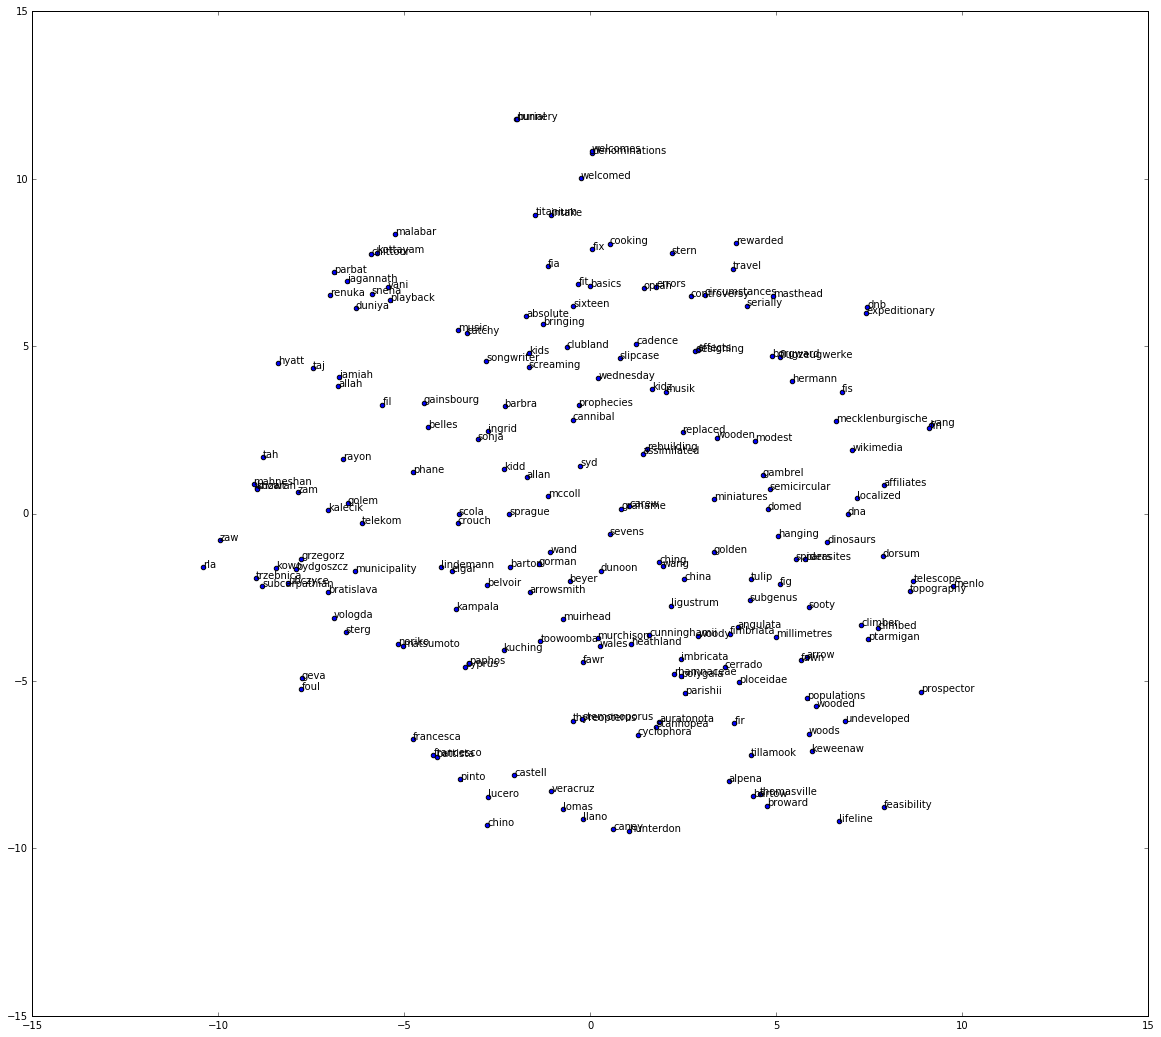

In [40]:
from sklearn.manifold import TSNE
from tsne import bh_sne

plt.rcParams['figure.figsize'] = (20, 18)

# load the word2vec model that we trained above and normalize the weights so that the memory footprint is smaller
model = gensim.models.Word2Vec.load("dbpedia_w2v_model")
model.init_sims(replace=True)

#model = gensim.models.Word2Vec.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)

# extract a vocab of 200 words from the model
vocab = list(model.vocab.keys())[:200]

# note that the w2v from google uses vectors of size 300
# we used vectors of size 64
wv = np.zeros((len(vocab), 64))
for i, key in enumerate(vocab):
    wv[i] = model[key].reshape(1, 64)
    
wv = np.nan_to_num(wv)

tsne = TSNE(n_components=2, random_state=0, verbose=1)
y = bh_sne(wv)

plt.scatter(y[:,0], y[:,1])
for label, x, y in zip(vocab, y[:,0], y[:,1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0), textcoords='offset points')
mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.show()


#### Load the trained model



In [41]:

# load the word2vec model that we trained above and normalize the weights so that the memory footprint is smaller
model = gensim.models.Word2Vec.load("dbpedia_w2v_model")
model.init_sims(replace=True)

# or we can load the pretrained word2vec model from google. 
# a good exercise to compare the results
#model = gensim.models.Word2Vec.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)

#### Set up some functions for making document comparisons

We only need to account for each word once so we have a uniqify function. 

We need a function to extract the embeddings from the trained model. With gensim's word2vec we simply just pass a string to the trained model and it will return the vector embedding. 

Come up with an algorithm to comparing documents. The one that I came up here was to compare each unique word in a query document to each word in the potential matching documents. When using the vector representations of words from word2vec we often use cosine similarity to find the most similar words. So I do each pair-wise comparison with cosine similarity. Calling this algorithm d-WAM for document word angle measurement. 

A labeled line sentence function to be consistent with gensim conventions. 

In [42]:
# only want unique words from text while preserving word order
def uniqify(seq, idfun=None):
    '''Thanks https://www.peterbe.com/plog/uniqifiers-benchmark'''
    # order preserving
    if idfun is None:
        def idfun(x): return x
    seen = {}
    result = []
    for item in seq:
        marker = idfun(item)
        if marker in seen: continue
        seen[marker] = 1
        result.append(item)
    return result

# extract vectors
def extract_embeddings(text, model):
    embedding_array = np.zeros((len(text), 64))
    for i, key in enumerate(text):
        embedding_array[i] = model[key].reshape(1,64)
    return embedding_array

# document word angle measurement
def d_wam(query_doc, check_doc, model):
    '''Modify this code to deal with word counts better'''
    query_array = np.array([model[w] for w in uniqify(query_doc)])
    check_array = np.array([model[w] for w in uniqify(check_doc)])
    distances = []
    for i in range(query_array.shape[0]):
        distance_mins = []
        # loop words in the second sentence
        for j in range(check_array.shape[0]):
            distance_mins.append(spatial.distance.cosine(query_array[i], check_array[j]))
            #distance_mins.append(spatial.distance.euclidean(query_array[i], check_array[j]))
        distances.append(np.amin(distance_mins))
    return np.sum(distances) / len(distances)

class LabeledLineSentence(object):
    '''
    Taken from the gensim word2vec tutorial
    By gensim convention we need to label each sentence when training. 
    '''
    def __init__(self, sources):
        self.sources = sources

    def __iter__(self):
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    yield LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no])

    def to_array(self):
        self.sentences = []
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                	self.sentences += [line]
        return self.sentences


### Do the document similarity search

We'll take an abstract to use as our query document. We are using the abstract for the Cash Money Records wikipedia article. 

* Load the dbpedia text document
* Label the sentences and convert it to an array
* Clean the the query abstract
* For each abstract calculate it's similarity metric against cash money records 
* Print the top ten most similar abstracts to see how we did

In [43]:
length = 200

# 'data/train-neg.txt':'TRAIN_NEG',
sources = {'data/dbpedia.txt':'TRAIN_POS'}
# sentences = LabeledLineSentence(sources).to_array()
sentences = random.sample(LabeledLineSentence(sources).to_array(), 12500)
sentences = [line[:length] for line in sentences]



# choose the first sentence
target = "Cash Money Records LLC is an American record label founded by brothers Bryan Birdman Williams and Ronald Slim Williams who currently act as CEOs. Today it operates as a subsidiary of Universal Music Group and is distributed by Republic Records formerly Universal Republic. The label currently includes artists such as Lil Wayne Drake Tyga Nicki Minaj Ace Hood Busta Rhymes DJ Khaled Jay Sean Kevin Rudolf Limp Bizkit and Mystikal among others."

# function to clean text
def clean_sentence(sent):
    return [w for w in sent.lower().split() if w in model.vocab and w not in stop_words.ENGLISH_STOP_WORDS]

scores = {}
for index, sentence in enumerate(sentences):
    sentence = clean_sentence(sentence)
    if len(sentence) > 0 and sentence != 'Ivo Pauwels Ivo Pauwels (1950) is a Flemish author.':
        #if index % 100 == 0: print index
        scores[index] = d_wam(clean_sentence(target), sentence, model)

sorted_list = sorted(scores.items(), key=lambda kv: kv[1])
top = sorted_list[:10]

print target
for index, score in top:
    print "\n"
    print sentences[index]


Cash Money Records LLC is an American record label founded by brothers Bryan Birdman Williams and Ronald Slim Williams who currently act as CEOs. Today it operates as a subsidiary of Universal Music Group and is distributed by Republic Records formerly Universal Republic. The label currently includes artists such as Lil Wayne Drake Tyga Nicki Minaj Ace Hood Busta Rhymes DJ Khaled Jay Sean Kevin Rudolf Limp Bizkit and Mystikal among others.


Capitol Records Capitol Records LLC is a major American record label that is part of the Capitol Music Group and is a wholly owned subsidiary of Universal Music Group. Founded in 1942 by three industr


Grand Hustle Records Grand Hustle Records also known as Hustle Gang Music is an Atlanta Georgia-based record label founded in 2003 by American hip hop recording artist T.I. and business partner Jason 


Ice Age Entertainment Ice Age Entertainment is a record label created and owned by southern rapper Mike Jones and business partner Ray Mello Moore. 